In [1]:
import os
os.chdir('..') # return to parent directory
from src.chessboard import *
from src.utils import *
import seaborn as sns

test = load_skimage(os.path.join(os.getcwd(),'notebooks','test.jpg')) # this function also rescales and converts to grayscale


c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Chessboard detection

In this notebook, an in depth explanation of the chessboard detection algorithm.

The main goal of the algorithm is to fit a `Chessboard` object to the image. This chessboard object is a mathematical representation of the chessboard, and is implemented as a Python class in the algorithm; the class holds the information of the location of the outer corners, that it uses to compute the location of the remaining inner corners of the chessboard. 

The chessboard object operates under the ideal pin-hole camera assumption: we assume that a projective homography is a sufficiently accurate transformation to correctly map the chessboard to the image (no radial distortion or other non linear effects).

A [homography](https://en.wikipedia.org/wiki/Homography_(computer_vision)) is a map in projective spaces; two images of the same planar surface are related via this transformation. A homography is fully determined by 8 parameters, i.e. the entries of the homography matrix except the last entry which is fixed to 1 because of scale invariance:

$$
H = 
\begin{pmatrix}
h_{1,1} & h_{1,2} & h_{1,3} \\
h_{2,1} & h_{2,2} & h_{2,3} \\
h_{3,1} & h_{3,2} & 1 
\end{pmatrix}
$$

These 8 parameters can be determined by the coordinates of 4 points that are mapped by this transformation.
In other words, if we can map a quadrilateral to another, we can compute the homography.

We could also obtain the parameters by fixing a line correspondence, but since we use the convenient OpenCV's implementation of computing a homography, we resort to the points correspondence.

The `chessboard` object has a method for computing a homography given the coordinates of four corners of the chessboard. The goal of the algorithm is to find the best points to warp to.

Let's start with a test image, taken from my phone; we already downsample it and convert to grayscale.

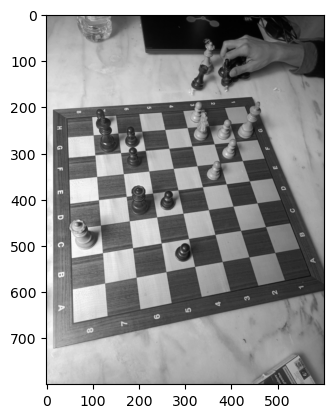

In [2]:
plt.imshow(test,cmap='gray')

## Hough Transform

Usually, when dealing with chessboard in image one tends to look for their prominent features, i.e. the alternating light and dark squares. These features translate to prominent patterns either in corner or line detection algorithms. In this implementation, we will deal with the lines, since we expect some of the corners to be obscured by the presence of the chess pieces.

The way to deal with lines is by computing a [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform); this transform takes a grid in the lines parameter space $(\rho,\theta)$, and compute the intensity of a given line in the image. Prominent peaks in the Hough transform are lines that occurr many times in the image.

The lines we are looking for are the edges separating the cells, so we first need to run an edge detector algorithm such as the [Canny algorithm](https://en.wikipedia.org/wiki/Canny_edge_detector). Then we compute the Hough transform using `skimage`'s implementation, along with a 2D peaks detection algorithm designed for the Hough transform, also provided by `skimage`.

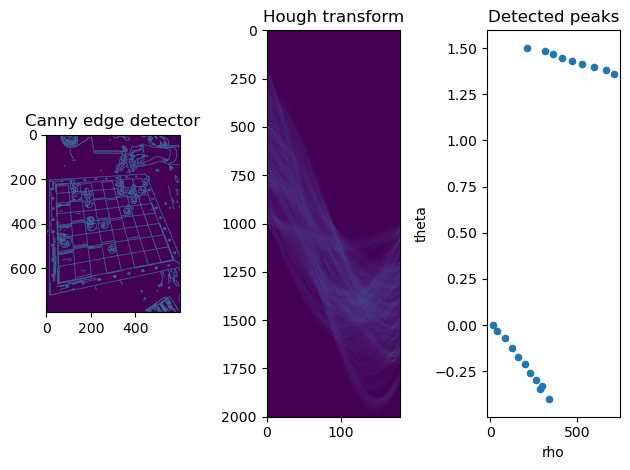

In [3]:
edges = canny(test)

# transform
hspace,angles,distances = hough_line(edges)

# get peaks
num_peaks=20
peaks = pd.DataFrame(hough_line_peaks(hspace,angles,distances,num_peaks=num_peaks,threshold=1)).T
peaks.columns = ['count','theta','rho']

fig,axs = plt.subplots(1,3)

axs[0].imshow(edges)
axs[0].set_title('Canny edge detector')
axs[1].imshow(hspace,aspect='auto')
axs[1].set_title('Hough transform')
peaks.plot.scatter(x='rho',y='theta',ax=axs[2])
axs[2].set_title('Detected peaks')

fig.tight_layout()

## RANSAC with sinusoidal curves

It can be seen that the detected peaks follow a peculiar pattern. They almost appear to lie on a straight line.

But actually, they lie on a sinusoidal curve: that is because lines that are parallel in a 3D space appear to meet in the _vanishing point_ when projected in the image plane. In the Hough space, each pixel represents a line that is parametrized as such:

$$
\rho = x \cos(\theta) + y \sin(\theta)
$$

so every line that passes through a point lies on a sinusoidal curve on the Hough space parametrized by $(x_0,y_0)$.

A chessboard has two bundle of parallel lines, so we can expect two sinusoidal patterns to form.

To detect the chessboard lines and remove outliers, we run a [RANSAC algorithm](https://en.wikipedia.org/wiki/Random_sample_consensus) which is an iterative method to select the best subset of inliers of a given model. It is usually seen with a linear model as an example, but we can fit a sinusoidal curve as defined previously, since the OLS solution is analytical, and can be derived by solving a linear system.



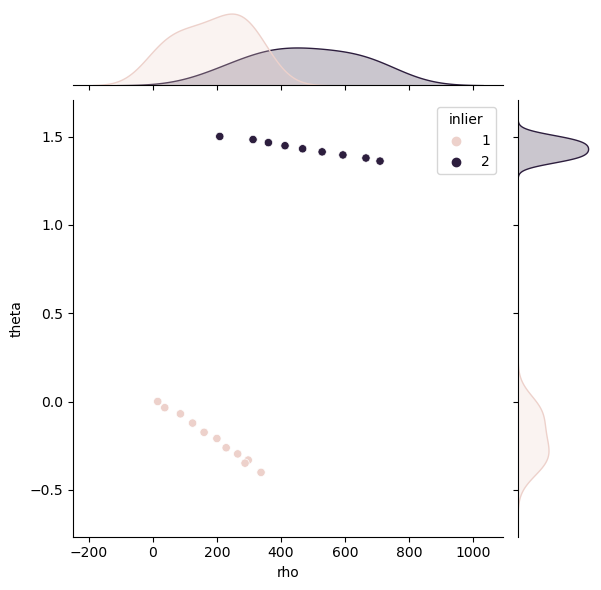

In [6]:
ransac_kwargs={'min_samples':8,'max_trials':5000}
# this runs two RANSAC algorithms
vp_1,vp_2,peaks,hspace,angles,distances=bootstrap_sinusoidal(edges,ransac_kwargs=ransac_kwargs)

sns.jointplot(data=peaks,x='rho',y='theta',hue='inlier')

## Chessboard detection

Next up, we select a couple lines from the subsets, via some statistical method. For now, we just pick the lines closest to the subset quantiles $q_1=0.4$ and $q_2=0.6$, hoping that we are drawing from the actual chessboard lines.

C:\Users\demle\AppData\Local\Temp\ipykernel_16824\4167410456.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  a = -np.cos(phi)/np.sin(phi)
C:\Users\demle\AppData\Local\Temp\ipykernel_16824\4167410456.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  b = rho/np.sin(phi)
C:\Users\demle\AppData\Local\Temp\ipykernel_16824\4167410456.py:13: RuntimeWarning: invalid value encountered in multiply
  axs[0].plot(x,a*x + b,color='red',linestyle='--')
C:\Users\demle\AppData\Local\Temp\ipykernel_16824\4167410456.py:13: RuntimeWarning: invalid value encountered in add
  axs[0].plot(x,a*x + b,color='red',linestyle='--')


Text(0.5, 1.0, 'Test lines')

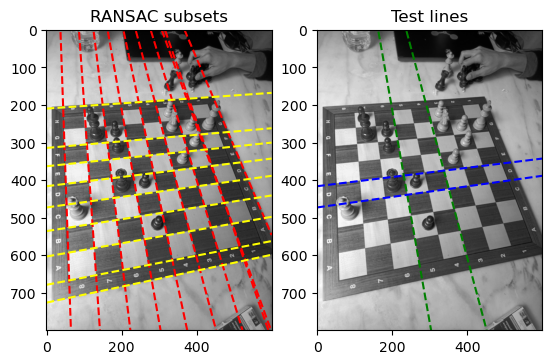

In [17]:
fig,axs = plt.subplots(1,2)


x = np.arange(test.shape[1])




for l in peaks[peaks.inlier==1][['rho','theta']].iterrows():
    rho,phi = l[1]
    a = -np.cos(phi)/np.sin(phi)
    b = rho/np.sin(phi)
    axs[0].plot(x,a*x + b,color='red',linestyle='--')

for l in peaks[peaks.inlier==2][['rho','theta']].iterrows():
    rho,phi = l[1]
    a = -np.cos(phi)/np.sin(phi)
    b = rho/np.sin(phi)
    axs[0].plot(x,a*x + b,color='yellow',linestyle='--')


axs[0].imshow(test,cmap='gray')

# grab the i-th row closest to the specified field median
def get_median_row(dataframe,column,distance=0):
    median = dataframe.median()[column]
    arg = abs(dataframe[column]-median).sort_values().index[distance]
    return dataframe.loc[arg]
    

# grab a couple lines
# two lines from one group
q1 = 0.4
q2 = 0.6

la1 = peaks[peaks.inlier==1][peaks[peaks.inlier==1].rho == peaks[peaks.inlier==1].rho.quantile(q1,interpolation='lower')][['rho','theta']].values[0]
lb1 = peaks[peaks.inlier==1][peaks[peaks.inlier==1].rho == peaks[peaks.inlier==1].rho.quantile(q2,interpolation='higher')][['rho','theta']].values[0]

la2 = peaks[peaks.inlier==2][peaks[peaks.inlier==2].rho == peaks[peaks.inlier==2].rho.quantile(q1,interpolation='lower')][['rho','theta']].values[0]
lb2 = peaks[peaks.inlier==2][peaks[peaks.inlier==2].rho == peaks[peaks.inlier==2].rho.quantile(q2,interpolation='lower')][['rho','theta']].values[0]

for line in [la1,lb1]:
    rho,phi = line
    a = -np.cos(phi)/np.sin(phi)
    b = rho/np.sin(phi)
    axs[1].plot(x,a*x + b,color='green',linestyle='--')

for line in [la2,lb2]:
    rho,phi = line
    a = -np.cos(phi)/np.sin(phi)
    b = rho/np.sin(phi)
    axs[1].plot(x,a*x + b,color='blue',linestyle='--')

axs[1].imshow(test,cmap='gray')

axs[0].set_title('RANSAC subsets')
axs[1].set_title('Test lines')

At this point, we do not know which lines we drew from the image; for each set of parallel lines, we may have sampled any lines $i,j$ with $i<j, j=1,2,..,9$.
So we check every combination of possible indices, and compute the four corners at which they intersect. Knowing which corners of the chessboard they correspond to (assuming the indices), we can evaluate a "fitness" function by drawing a "chessboard filter", i.e. a black image (a zero-filled matrix) with the chessbaord drawn on it, and compute the response of this filter by multiplying it with the Canny processed image.


In [25]:
def test_lines(la1,lb1,la2,lb2,edges):

    chessboard = Chessboard()
    best_loss = np.inf

    for i in range(0,7):
        for j in range(i+1,8):
            for k in range(0,7):
                for l in range(k+1,8):

                    chessboard.warp_from_lines(np.array([la1,lb1,la2,lb2]),(i,j,k,l))
                    # loss = chessboard_loss_transform(chessboard,hspace,angles,distances)
                    loss = -(chessboard.draw_filter(*edges.shape,thickness=100)*edges).sum()
                    
                    
                    
                    
                    if loss < best_loss:
                        best_loss = loss
                        best_chessboard = copy.deepcopy(chessboard)
    
    return best_chessboard,best_loss

# this performs the combinatorial search
best_chessboard,best_loss = test_lines(la1,la2,lb1,lb2,edges)

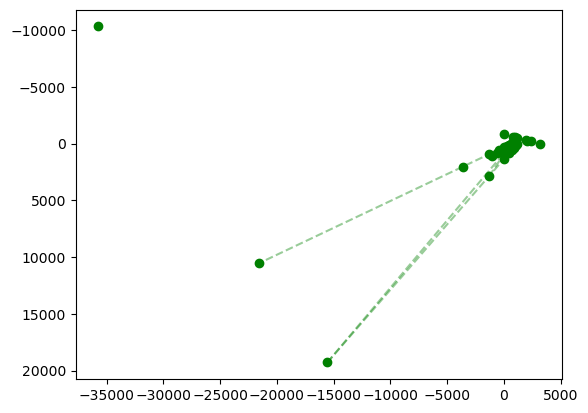

In [26]:
fig,ax=plt.subplots()
ax.imshow(test,cmap='gray')
best_chessboard.plot_chessboard(ax=ax)
